In [1]:
import math
import random
import numpy as np
from datetime import datetime
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
config = tf.compat.v1.ConfigProto()
tf.config.list_physical_devices('GPU')
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

In [3]:
import os
train_dir = f"{os.getcwd()}\\..\\data\\tr"
batch_size = 32
time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

In [4]:
def labeler(example, index):
    return example, tf.cast(index, tf.int64)

In [5]:
FILE_NAMES = ['combinedneg.txt', 'combinedneut2.txt', 'combinedpos.txt']
labeled_data_sets = []
# Give labels to the data, 0 for negatives, 1 for neutrals, 2 for positives.
for i, file_name in enumerate(FILE_NAMES):
    lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\{file_name}")
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    labeled_data_sets.append(labeled_dataset)

In [6]:
BUFFER_SIZE = 50000

In [7]:
# concatenate all labeled datasets into one and shuffle
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)
all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

In [8]:
DATASET_SIZE = [i for i,_ in enumerate(all_labeled_data)][-1] + 1
BATCH_SIZE = 32
VALIDATION_SIZE = math.ceil(DATASET_SIZE * 0.1)
VOCAB_SIZE = 45000

In [9]:
print('Labels are 0 = negative, 1 = neutral, 2 = positive.\n')
for text, label in all_labeled_data.take(1):
    print("Sentence: ", text.numpy())
    print("Label:", label.numpy())

Labels are 0 = negative, 1 = neutral, 2 = positive.

Sentence:  b'ja hyvin t\xc3\xa4rke\xc3\xa4\xc3\xa4 on ett\xc3\xa4 katsot henkil\xc3\xb6\xc3\xa4 silmiin.'
Label: 1


In [10]:
train_dataset = all_labeled_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = all_labeled_data.take(VALIDATION_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])
encoder = TextVectorization()
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())
print(len(vocab), vocab[:20])
encoded_example = encoder(example)[:3].numpy()
print(encoded_example)
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

texts:  [b'en haluaisi menett\xc3\xa4\xc3\xa4 pearli\xc3\xa4.'
 b'tein virheit\xc3\xa4, koska olen vain ihminen.'
 b'pysy rohkeana, prinsessa.']

labels:  [0 2 2]
54753 ['' '[UNK]' 'on' 'ja' 'ei' 'että' 'se' 'ole' 'en' 'mutta' 'kun' 'jos'
 'niin' 'hän' 'olen' 'mitä' 'oli' 'voi' 'nyt' 'kuin']
[[    8   665  1355 12570     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [  580  2402    77    14    21   257     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [ 1112 28672  2800     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Original:  b'en haluaisi menett\xc3\xa4\xc3\xa4 pearli\xc3\xa4.'
Round-trip:  en haluaisi menettää pearliä               

Original:  b'tein virheit\xc3\xa4, koska olen vain ihminen.'
Round-trip:  tein virheitä koska olen vain ihminen             

Original:  b'pysy rohkeana, prinsessa.'
Round-trip:  pysy rohkeana prinsessa                



In [12]:
import pickle
with open("..\\data\\others\\vocab2.pickle", "wb") as output_file:
    pickle.dump(vocab, output_file)

In [13]:
def create_model(num_labels):
    model_layers = tf.keras.Sequential([
        encoder,
        layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, embeddings_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), mask_zero=True),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(32)),
        layers.Dropout(0.20),
        layers.Dense(32, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activation='relu'),
        layers.Dropout(0.20),
        layers.Dense(num_labels),
        layers.Activation('softmax')])
    return model_layers

In [14]:
model = create_model(num_labels=3)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=1)
model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss=losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=test_dataset, callbacks=[early_stop], epochs=15)
model.summary()

Epoch 1/15
979/979 [==============================] - 79s 81ms/step - loss: 1.2440 - accuracy: 0.4887 - val_loss: 0.9400 - val_accuracy: 0.5590
Epoch 2/15
979/979 [==============================] - 74s 76ms/step - loss: 0.8805 - accuracy: 0.6154 - val_loss: 0.8659 - val_accuracy: 0.6398
Epoch 3/15
979/979 [==============================] - 76s 78ms/step - loss: 0.7517 - accuracy: 0.7146 - val_loss: 0.8408 - val_accuracy: 0.6788
Epoch 4/15
979/979 [==============================] - 78s 79ms/step - loss: 0.5950 - accuracy: 0.8107 - val_loss: 0.8811 - val_accuracy: 0.7030
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          3504192   
_________________________________________________________________
bidirect

In [16]:
model.save(f'model/rnn_{time}')
# model.save(f'model/rnn_{time}.h5')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause:

In [17]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

109/109 [==============================] - 2s 19ms/step - loss: 0.8811 - accuracy: 0.7030
Test Loss: 0.8811458945274353
Test Accuracy: 0.7029589414596558


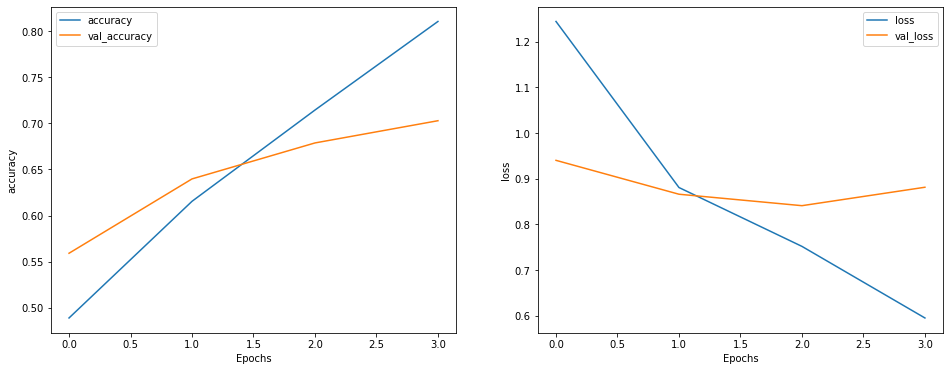

In [18]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [19]:
modelpath = f"model/rnn_{time}"
import_model = tf.keras.models.load_model(modelpath)
import_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          3504192   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

In [20]:
n = 5
inputs = []
with open(f"D:\\Work\\Data\\s24_2001_sentences_shuffled_slice.txt", 'r', encoding='utf-8') as f:
    lines = f.readlines()
    random.shuffle(lines)
    for line in lines:
        inputs.append(line.strip('\n'))
inputs = np.array(inputs[:n])
print(inputs[:n])

['Olen aina nauttinut flirttailusta, mutta koska en halua mieheni tekevän sitä, en tee itsekään. '
 'H600:sella voit säätää subin tason pääkaiuttimiin nähden ja valita jakotaajuuden. '
 'Koska ihminen oli olemassa siihen aikaan, niin siitä ei voi olla kovin kauaa aikaa, puhutaan ehkä alle 10.000 vuodesta? '
 'en toki MINÄ kuvitellut sinun yrittävän iskeä minua, olisihan se aivan mahdoton tehtävä - kun näin outoja näkymättömiä ollaan. '
 'Vaihtoehtoja "maailmanlopulle" nykytietämyksen mukaan on tietääkseni kolme (ainakin). ']


In [21]:
def make_prediction(inps):
    predicted_scores = import_model.predict(np.array(inps))
    predicted_labels = tf.argmax(predicted_scores, axis=1)
    lab, pred = '', ''
    labs, preds = [], []
    for i, (inp, label) in enumerate(zip(inputs, predicted_labels)):
        pred = (', '.join(f'{q:.5f}' for q in predicted_scores[i]))
        lab = label.numpy()
        print(f"Sentence: {inp}")
        print(f"Predicted label: {lab}")
        print(f"Predicted probs: {pred}\n")
        labs.append(lab)
        preds.append(pred)
    return labs, preds

print(np.array(inputs), '\n\n', make_prediction(inputs))

Sentence: Olen aina nauttinut flirttailusta, mutta koska en halua mieheni tekevän sitä, en tee itsekään. 
Predicted label: 1
Predicted probs: 0.00039, 0.99893, 0.00068

Sentence: H600:sella voit säätää subin tason pääkaiuttimiin nähden ja valita jakotaajuuden. 
Predicted label: 1
Predicted probs: 0.00096, 0.99231, 0.00673

Sentence: Koska ihminen oli olemassa siihen aikaan, niin siitä ei voi olla kovin kauaa aikaa, puhutaan ehkä alle 10.000 vuodesta? 
Predicted label: 1
Predicted probs: 0.00424, 0.81504, 0.18072

Sentence: en toki MINÄ kuvitellut sinun yrittävän iskeä minua, olisihan se aivan mahdoton tehtävä - kun näin outoja näkymättömiä ollaan. 
Predicted label: 1
Predicted probs: 0.00236, 0.93905, 0.05859

Sentence: Vaihtoehtoja "maailmanlopulle" nykytietämyksen mukaan on tietääkseni kolme (ainakin). 
Predicted label: 2
Predicted probs: 0.14812, 0.20004, 0.65184

['Olen aina nauttinut flirttailusta, mutta koska en halua mieheni tekevän sitä, en tee itsekään. '
 'H600:sella voit sää